In [1]:
import pickle
import json
import copy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from seededHierarchicalDensityClustering import SeededHierarchicalDensityClustering
from evaluateSHDC_wos import evaluate, print_metrics

In [2]:
method = 'pool'
embedding_type = 'roberta' # roberta, glove300, fastText

dataset_name = 'wos46985'
base_dir = '../../data/WOS/'
data_file = base_dir+'Meta-data/Data.csv'

text_embedding_dir = '../data/'+dataset_name
text_embedding_file = text_embedding_dir+'/'+embedding_type+'-embedding-'+method+'.pkl'

seed_indices_file = text_embedding_dir+'/seed_indices.json'
remaining_indices_file = text_embedding_dir+'/remaining_indices.json'
data_indices_test_file = text_embedding_dir+'/data_indices_test.json'
data_indices_train_file = text_embedding_dir+'/data_indices_train.json'

seed_embeddings_file = text_embedding_dir+'/cluster_hierarchy_seed_embeddings-roberta-'+method+'.pkl'

### Read Original Topic Seeds

In [3]:
topic_seeds = pickle.load(open(seed_embeddings_file, "rb"))

### Read Text Embeddings

In [4]:
text_embeddings = pickle.load(open(text_embedding_file, "rb"))

with open(remaining_indices_file, "r") as infile:
    remaining = json.load(infile)

data_indices = []
for parent in remaining.keys():
    for child in remaining[parent]['sub-topic'].keys():
        data_indices.extend(remaining[parent]['sub-topic'][child]['indices'])

In [5]:
data_indices_train, data_indices_test = train_test_split(data_indices, test_size=0.33,random_state= 0)

In [6]:
print(len(data_indices),len(data_indices_train), len(data_indices_test))

with open(data_indices_train_file, "w") as outfile:
    json.dump(data_indices_train, outfile, indent = 4)
with open(data_indices_test_file, "w") as outfile:
    json.dump(data_indices_test, outfile, indent = 4)

46424 31104 15320


In [7]:
X = text_embeddings[data_indices_train]
X.shape

(31104, 768)

In [8]:
def eval(topic_seeds, topics_points_hierarchical, topics_points_distances_hierarchical, sub_topics_points_distances):
    init_neighbors_perc = 0.4
    metrics_1 = evaluate(
        dataset_name, topic_seeds, 'both', topics_points_hierarchical,
        topics_points_distances_hierarchical, sub_topics_points_distances
    )
    return metrics_1

### Train Cluster

In [9]:
## Hyperparameters (determined by experiments)

main_topic_update_method = 2
main_topic_weight = 5

init_neighbors_perc = 0.75

create_other_main = False
create_other_sub = True

In [10]:
shdc = SeededHierarchicalDensityClustering(
    topic_seeds,
    init_neighbors_perc=init_neighbors_perc,
    main_topic_update_method=main_topic_update_method, 
    main_topic_weight=main_topic_weight,
    create_other_main=create_other_main, 
    create_other_sub=create_other_sub,
    verbose=False
)

In [11]:
num_iter = 15
metrics = []
iter_weights = []

try:
    for i in range(num_iter):
        print('Iteration',i+1,':')
        print('    Fitting...')
        ## Get L1 Assignments
        shdc.fit_L1(X)
        ## Get L2 Assignments
        shdc.fit_L2(X)

        ## Get Weights
        topic_seeds = copy.deepcopy(shdc.topic_seeds)
        topic_distance_threshold = copy.deepcopy(shdc.topic_distance_threshold)
        topic_seeds_updated = copy.deepcopy(shdc.topic_seeds_updated)
        topic_distance_threshold_updated = copy.deepcopy(shdc.topic_distance_threshold_updated)

        iter_weights.append(
            (topic_seeds, topic_distance_threshold)
        )

        ## Evaluate
        print('    Evaluating...')
        metr = eval(topic_seeds, shdc.topics_points_hierarchical, shdc.topics_points_distances_hierarchical, shdc.sub_topics_points_distances)
        metrics.append(metr)

        ## Iterate
        shdc.topic_seeds = shdc.topic_seeds_updated
        main_topic_weight += 1    # increasing weight
        shdc.main_topic_weight = main_topic_weight

        print('    Completed...')
except:
    pass

Iteration 1 :
    Fitting...
    Evaluating...
    Completed...
Iteration 2 :
    Fitting...
    Evaluating...
    Completed...
Iteration 3 :
    Fitting...
    Evaluating...
    Completed...
Iteration 4 :
    Fitting...
    Evaluating...
    Completed...
Iteration 5 :
    Fitting...
    Evaluating...
    Completed...
Iteration 6 :
    Fitting...
    Evaluating...
    Completed...
Iteration 7 :
    Fitting...
    Evaluating...
    Completed...
Iteration 8 :
    Fitting...
    Evaluating...
    Completed...
Iteration 9 :
    Fitting...
    Evaluating...
    Completed...
Iteration 10 :
    Fitting...
    Evaluating...
    Completed...
Iteration 11 :
    Fitting...
    Evaluating...
    Completed...
Iteration 12 :
    Fitting...
    Evaluating...
    Completed...
Iteration 13 :
    Fitting...
    Evaluating...
    Completed...
Iteration 14 :
    Fitting...
    Evaluating...
    Completed...
Iteration 15 :
    Fitting...
    Evaluating...
    Completed...


### Plot

In [12]:
homogeneity_l1 = []
completeness_l1 = []
v_measure_l1 = []
homogeneity_l2 = []
completeness_l2 = []
v_measure_l2 = []
homogeneity_l3 = []
completeness_l3 = []
v_measure_l3 = []
precision_l1 = []
recall_l1 = []
fscore_l1 = []
precision_l2 = []
recall_l2 = []
fscore_l2 = []
precision_l3 = []
recall_l3 = []
fscore_l3 = []
accuracy_l1 = []
accuracy_l2 = []
accuracy_l3 = []

for m in metrics:
    homogeneity_l1.append(m['L1']['homogeneity'])
    completeness_l1.append(m['L1']['completeness'])
    v_measure_l1.append(m['L1']['v_measure'])
    homogeneity_l2.append(m['L2']['homogeneity'])
    completeness_l2.append(m['L2']['completeness'])
    v_measure_l2.append(m['L2']['v_measure'])
    homogeneity_l3.append(m['L3']['homogeneity'])
    completeness_l3.append(m['L3']['completeness'])
    v_measure_l3.append(m['L3']['v_measure'])
    precision_l1.append(m['L1']['precision'])
    recall_l1.append(m['L1']['recall'])
    fscore_l1.append(m['L1']['fscore'])
    precision_l2.append(m['L2']['precision'])
    recall_l2.append(m['L2']['recall'])
    fscore_l2.append(m['L2']['fscore'])
    precision_l3.append(m['L3']['precision'])
    recall_l3.append(m['L3']['recall'])
    fscore_l3.append(m['L3']['fscore'])
    accuracy_l1.append(m['L1']['accuracy'])
    accuracy_l2.append(m['L2']['accuracy'])
    accuracy_l3.append(m['L3']['accuracy'])

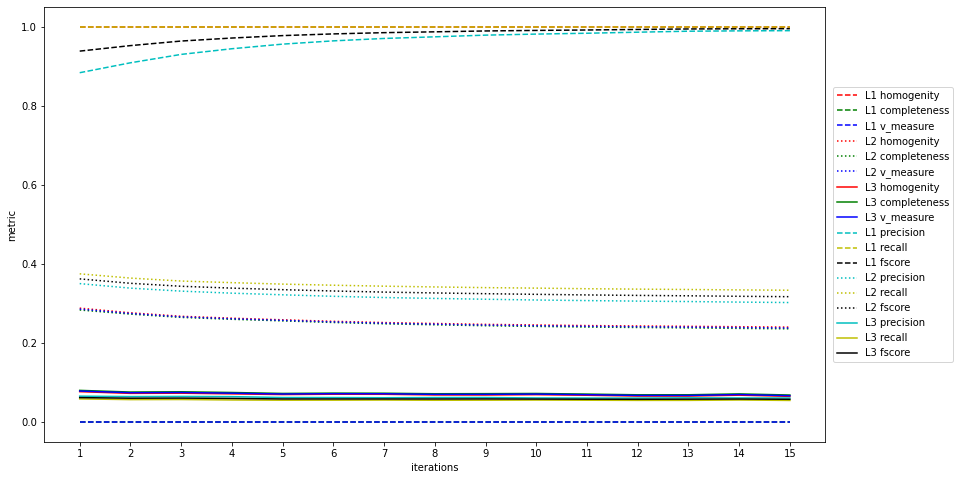

In [13]:
plt.plot(homogeneity_l1, label='L1 homogenity', c='r', ls='--')
plt.plot(completeness_l1, label='L1 completeness', c='g', ls='--')
plt.plot(v_measure_l1, label='L1 v_measure', c='b', ls='--')

plt.plot(homogeneity_l2, label='L2 homogenity', c='r', ls=':')
plt.plot(completeness_l2, label='L2 completeness', c='g', ls=':')
plt.plot(v_measure_l2, label='L2 v_measure', c='b', ls=':')

plt.plot(homogeneity_l3, label='L3 homogenity', c='r', ls='-')
plt.plot(completeness_l3, label='L3 completeness', c='g', ls='-')
plt.plot(v_measure_l3, label='L3 v_measure', c='b', ls='-')


plt.plot(precision_l1, label='L1 precision', c='c', ls='--')
plt.plot(recall_l1, label='L1 recall', c='y', ls='--')
plt.plot(fscore_l1, label='L1 fscore', c='k', ls='--')

plt.plot(precision_l2, label='L2 precision', c='c', ls=':')
plt.plot(recall_l2, label='L2 recall', c='y', ls=':')
plt.plot(fscore_l2, label='L2 fscore', c='k', ls=':')

plt.plot(precision_l3, label='L3 precision', c='c', ls='-')
plt.plot(recall_l3, label='L3 recall', c='y', ls='-')
plt.plot(fscore_l3, label='L3 fscore', c='k', ls='-')

plt.legend(loc='center right', bbox_to_anchor=(1.17, 0.5))
x = list(range(1,len(accuracy_l1)+1))
plt.xticks(list(range(len(x))), x)
plt.xlabel('iterations')
plt.ylabel('metric')

plt.gcf().set_size_inches(14, 8)

plt.show()

### Select Best Weights

In [14]:
best_iter = 1

best_topic_seeds, best_topic_distance_threshold = iter_weights[best_iter-1]

### Write Learnt Threshold to file

In [15]:
topic_distance_threshold_file = '../model/'+dataset_name+'/topic_distance_threshold.pkl'
pickle.dump(best_topic_distance_threshold, open(topic_distance_threshold_file, "wb"))

### Write Learnt Seeds to file

In [16]:
topic_seed_file ='../model/'+dataset_name+'/cluster_hierarchy_seed_embeddings-roberta-'+method+'.pkl'
pickle.dump(best_topic_seeds, open(topic_seed_file, "wb"))

### Write Model Parameters

In [17]:
params = {
    "main_topic_update_method": main_topic_update_method,
    "main_topic_weight": main_topic_weight,
    "init_neighbors_perc": init_neighbors_perc,
    "create_other_main": create_other_main,
    "create_other_sub": create_other_sub,
    "best_iter":best_iter
}

In [18]:
model_parameters_file = '../model/'+dataset_name+'/model_parameters.pkl'
pickle.dump(params, open(model_parameters_file, "wb"))

In [19]:
model_parameters_file, topic_seed_file, topic_distance_threshold_file

('../model/wos46985/model_parameters.pkl',
 '../model/wos46985/cluster_hierarchy_seed_embeddings-roberta-pool.pkl',
 '../model/wos46985/topic_distance_threshold.pkl')